In [ ]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import os
import math
from sklearn.preprocessing import PolynomialFeatures
from itertools import product


INPUT_FILE = "suburb_info.xlsx"
FEATURES = ["number_of_houses", "number_of_units", "population", "aus_born_perc", "median_income"]
TARGET = "median_house_price"
LAMBDAS = [-1.0, -0.5, 0.0, 0.5, 1.0]
SCALERS = ["minmax", "robust", "zscore"]
CV_FOLDS = 3
RANDOM_STATE = 0

# Load
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"Could not find {INPUT_FILE} in the working directory. Make sure the file is present.")

df = pd.read_excel(INPUT_FILE)

# Convert 'aus_born_perc' from '67%' → 67.0 (float)
df["aus_born_perc"] = df["aus_born_perc"].astype(str).str.replace('%', '', regex=False)
df["aus_born_perc"] = pd.to_numeric(df["aus_born_perc"], errors="coerce")

# Convert 'median_income' from '$1,583' → 1583 (int)
df["median_income"] = (
    df["median_income"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# Convert 'median_house_price' from '$1,148,100' → 1148100 (int)
df["median_house_price"] = (
    df["median_house_price"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# Check positives (Box-Cox requires > 0)
for col in FEATURES + [TARGET]:
    if (df[col] <= 0).any():
        raise ValueError(f"Column {col} contains non-positive values; Box-Cox requires strictly positive values.")

X_orig = df[FEATURES].astype(float).copy()
y = df[TARGET].astype(float).copy()

results = []
kf = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
model = LinearRegression()

lambda_combos = list(itertools.product(LAMBDAS, repeat=len(FEATURES)))


# candidate_lambdas = np.arange(-1, 1.5, 0.5)
# lambda_candidates = {}

# for col in FEATURES:
#     x = X_orig[col].values
#     best = []
#     for lam in candidate_lambdas:
#         try:
#             x_bc = stats.boxcox(x, lmbda=lam)
#             corr = abs(np.corrcoef(x_bc, y)[0, 1])
#             best.append((lam, corr))
#         except Exception:
#             continue
#     top_lams = sorted(best, key=lambda t: -t[1])[:3]
#     lambda_candidates[col] = [t[0] for t in top_lams]

# print(lambda_candidates)

# lambda_combos = list(product(
#     lambda_candidates["number_of_houses"],
#     lambda_candidates["number_of_units"],
#     lambda_candidates["population"],
#     lambda_candidates["aus_born_perc"],
#     lambda_candidates["median_income"]
# ))
total_runs = len(SCALERS) * len(lambda_combos)
print(f"Total runs to evaluate: {total_runs}")

for scaler_name in SCALERS:
    for lambdas in lambda_combos:
        # Box-Cox transform each feature with its lambda
        X_trans = np.zeros_like(X_orig.values, dtype=float)
        for i, col in enumerate(FEATURES):
            lam = lambdas[i]
            X_trans[:, i] = stats.boxcox(X_orig.iloc[:, i].values, lmbda=lam)

        # Scale
        if scaler_name == "minmax":
            scaler = MinMaxScaler(feature_range=(0, 1))
        elif scaler_name == "robust":
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_trans)
        # After scaling
        poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
        X_interact = poly.fit_transform(X_scaled)

        # CV
        r2_scores = cross_val_score(model, X_interact, y.values, cv=kf, scoring="r2")
        neg_mse_scores = cross_val_score(model, X_interact, y.values, cv=kf, scoring="neg_mean_squared_error")
        mse_scores = -neg_mse_scores
        rmse_scores = np.sqrt(mse_scores)

        results.append({
            "scaler": scaler_name,
            "lambdas": tuple(lambdas),
            "mean_R2": float(np.mean(r2_scores)),
            "std_R2": float(np.std(r2_scores)),
            "mean_RMSE": float(np.mean(rmse_scores)),
            "std_RMSE": float(np.std(rmse_scores))
        })

res_df = pd.DataFrame(results).sort_values(by="mean_R2", ascending=False).reset_index(drop=True)
out_path = "boxcox_scaling_results.csv"
res_df.to_csv(out_path, index=False)

print("Best result (by mean R^2):")
best = res_df.iloc[0]
print(f"  scaler: {best['scaler']}")
print(f"  lambdas (per feature order {FEATURES}): {best['lambdas']}")
print(f"  mean R^2: {best['mean_R2']:.6f} (std {best['std_R2']:.6f})")
print(f"  mean RMSE: {best['mean_RMSE']:.6f} (std {best['std_RMSE']:.6f})")
print(f"All results saved to: {out_path}")


{'number_of_houses': [np.float64(1.0), np.float64(-1.0), np.float64(0.5)], 'number_of_units': [np.float64(0.5), np.float64(1.0), np.float64(0.0)], 'population': [np.float64(1.0), np.float64(0.5), np.float64(0.0)], 'aus_born_perc': [np.float64(-1.0), np.float64(-0.5), np.float64(0.0)], 'median_income': [np.float64(1.0), np.float64(0.5), np.float64(0.0)]}
Total runs to evaluate: 729
Best result (by mean R^2):
  scaler: robust
  lambdas (per feature order ['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income']): (np.float64(0.5), np.float64(0.0), np.float64(1.0), np.float64(-1.0), np.float64(1.0))
  mean R^2: 0.668411 (std 0.081262)
  mean RMSE: 269381.723771 (std 38965.688956)
All results saved to: boxcox_scaling_results.csv


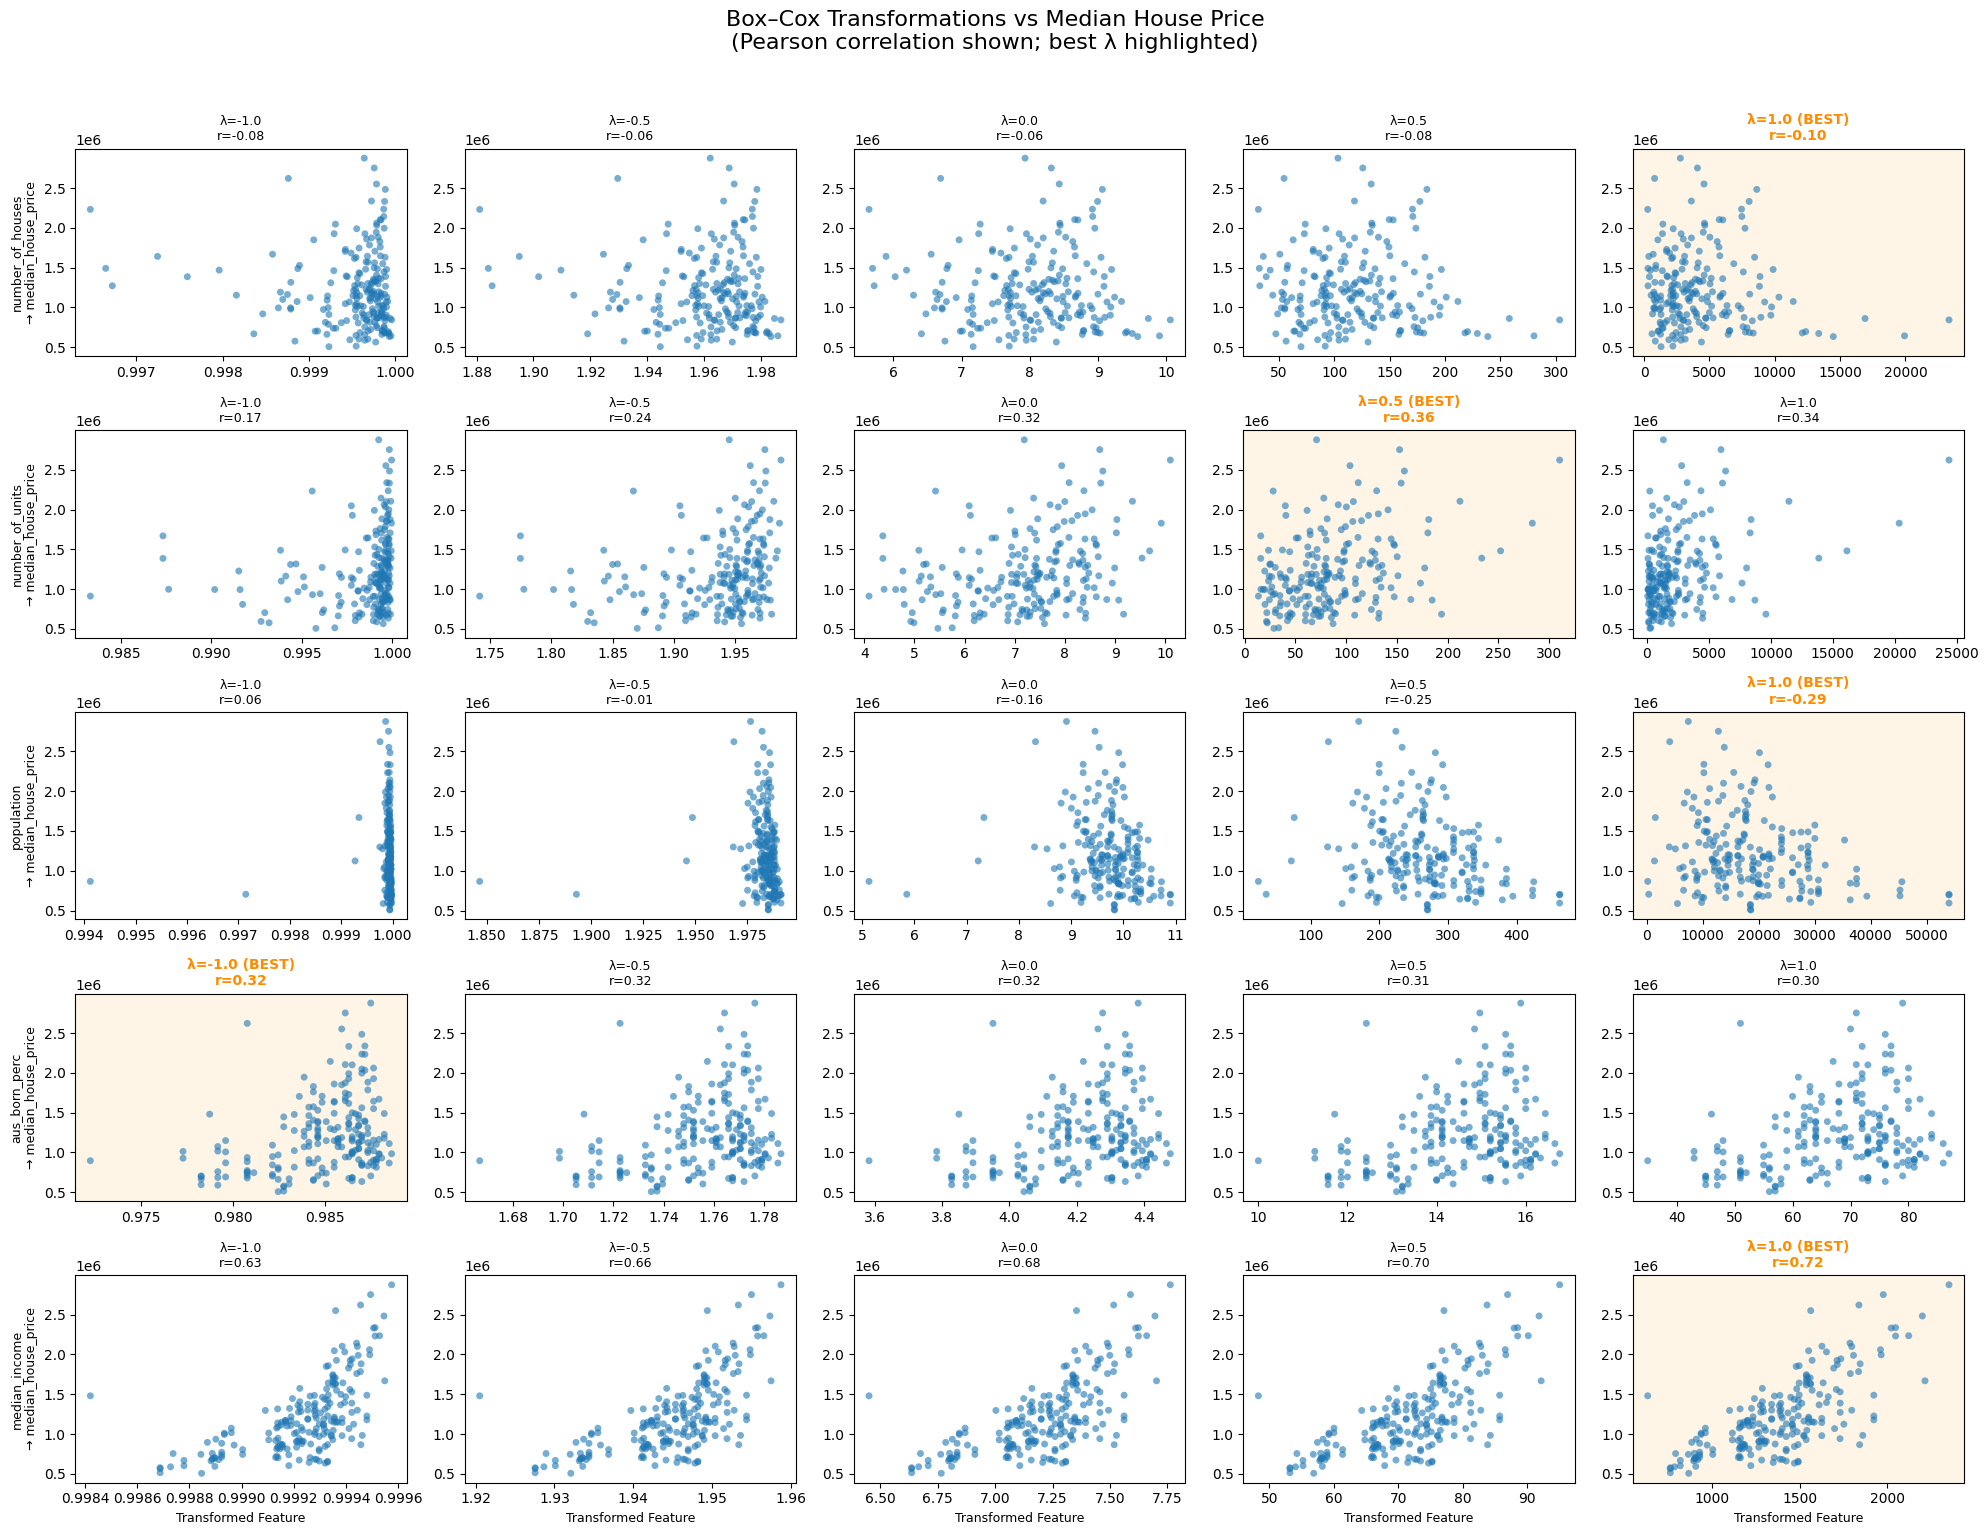

=== Best λ per feature (by |Pearson r| with median_house_price) ===
         feature  best_lambda  best_abs_corr
   median_income          1.0       0.719384
 number_of_units          0.5       0.355216
   aus_born_perc         -1.0       0.320922
      population          1.0       0.287242
number_of_houses          1.0       0.104490


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox, pearsonr
import os

INPUT_FILE = "suburb_info.xlsx"
FEATURES = ["number_of_houses", "number_of_units", "population", "aus_born_perc", "median_income"]
TARGET = "median_house_price"
LAMBDAS = [-1.0, -0.5, 0.0, 0.5, 1.0]

# Load
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"Could not find {INPUT_FILE} in the working directory. Make sure the file is present.")

df = pd.read_excel(INPUT_FILE)

# Convert 'aus_born_perc' from '67%' → 67.0 (float)
df["aus_born_perc"] = df["aus_born_perc"].astype(str).str.replace('%', '', regex=False)
df["aus_born_perc"] = pd.to_numeric(df["aus_born_perc"], errors="coerce")

# Convert 'median_income' from '$1,583' → 1583 (int)
df["median_income"] = (
    df["median_income"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# Convert 'median_house_price' from '$1,148,100' → 1148100 (int)
df["median_house_price"] = (
    df["median_house_price"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# Check positives (Box-Cox requires > 0)
for col in FEATURES + [TARGET]:
    if (df[col] <= 0).any():
        raise ValueError(f"Column {col} contains non-positive values; Box-Cox requires strictly positive values.")


y = df[TARGET].values

# === COMPUTE BOX–COX TRANSFORMS AND CORRELATIONS ===
corr_map = {}  # store best correlation info
transformations = {}

for col in FEATURES:
    x = df[col].values
    corr_list = []
    x_transformed = []
    for lam in LAMBDAS:
        try:
            x_bc = boxcox(x, lmbda=lam)
            r, _ = pearsonr(x_bc, y)
        except Exception:
            x_bc = np.full_like(x, np.nan)
            r = np.nan
        corr_list.append(r)
        x_transformed.append(x_bc)
    corr_map[col] = {
        "best_lambda": LAMBDAS[np.nanargmax(np.abs(corr_list))],
        "best_r": np.nanmax(np.abs(corr_list)),
        "r_values": corr_list
    }
    transformations[col] = x_transformed

# === PLOT ===
fig, axes = plt.subplots(len(FEATURES), len(LAMBDAS),
                         figsize=(20, 15), sharey=False)
fig.suptitle("Box–Cox Transformations vs Median House Price\n(Pearson correlation shown; best λ highlighted)",
             fontsize=16, y=1.02)

for i, col in enumerate(FEATURES):
    best_lam = corr_map[col]["best_lambda"]
    best_r = corr_map[col]["best_r"]

    for j, lam in enumerate(LAMBDAS):
        x_bc = transformations[col][j]
        r = corr_map[col]["r_values"][j]
        ax = axes[i, j]
        ax.scatter(x_bc, y, alpha=0.6, s=25, edgecolor='none')

        # highlight best λ with colored border / title
        if lam == best_lam:
            ax.set_facecolor("#fff5e6")  # light highlight background
            ax.set_title(f"λ={lam:.1f} (BEST)\nr={r:.2f}", fontsize=10, fontweight='bold', color='darkorange')
        else:
            ax.set_title(f"λ={lam:.1f}\nr={r:.2f}", fontsize=9)

        if j == 0:
            ax.set_ylabel(f"{col}\n→ {TARGET}", fontsize=9)
        if i == len(FEATURES) - 1:
            ax.set_xlabel("Transformed Feature", fontsize=9)

plt.tight_layout()
plt.show()

# === PRINT SUMMARY TABLE ===
summary = pd.DataFrame({
    "feature": FEATURES,
    "best_lambda": [corr_map[c]["best_lambda"] for c in FEATURES],
    "best_abs_corr": [corr_map[c]["best_r"] for c in FEATURES]
}).sort_values(by="best_abs_corr", ascending=False)

print("=== Best λ per feature (by |Pearson r| with median_house_price) ===")
print(summary.to_string(index=False))


To identify how to best scale and transform these features for a linear regression model, we decided that the best way is
to create the linear regression model and evaluate the performance by its r^2 value. This is because this method allows for
us to run a grid search of every permutation of scaling choice and feature transforms for each variable, and yields objective,
measurable, qualitative answers. It is convenient that the dataset and number of features we are testing is small, but if they
were not, we could simply subsample the dataset.

As for the results:  
Trying to prune the lambda permutations reduced the run-time drastically, but it did not get the same best results, so it was not used.  
Increasing the range from [-1, 1] to [-5, 5] thus actually made worse results after pruning lambda permutations, so it was not used.  
The choice of scaling turns out to have very minimal difference in the fitting of a linear regression model.   
Improvements in R^2: 0.61420 (no transforms) to 0.67447 (best transform found), a modest but not incredible difference.    
Fitting the data to a linear regression model with interaction terms lowered the best performance to 0.67041, so it was not used.  
The best results were (0.5, 0.0, -0.5, -1.0, 1.0) for simple linear regression model.  
With interaction terms, it became (0.5, 0.0, 1.0, -0.5, 1.0)

Visual inspection + pearson correlationsy it is (1.0, 0.5, 1.0, -1.0, 1.0)

robust,"(0.5, 0.0, -0.5, -1.0, 1.0)",0.6744749599271418,0.07321400376578074,267153.6001071059,36083.93759680057
zscore,"(np.float64(0.5), np.float64(0.0), np.float64(1.0), np.float64(-0.5), np.float64(1.0))",0.6704104219788771,0.10829523195136556,267191.00592368323,49521.262701889646

(np.float64(0.5), np.float64(0.0), np.float64(-0.5), np.float64(-1.0), np.float64(1.0))

Pruned lambda permutations, interaction terms
Total runs to evaluate: 729
Best result (by mean R^2):
  scaler: zscore
  lambdas (per feature order ['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income']): (np.float64(0.5), np.float64(0.0), np.float64(1.0), np.float64(-0.5), np.float64(1.0))
  mean R^2: 0.670410 (std 0.108295)
  mean RMSE: 267191.005924 (std 49521.262702)
All results saved to: boxcox_scaling_results.csv

Pruned lambda permutations, simple model
Total runs to evaluate: 729
Best result (by mean R^2):
  scaler: robust
  lambdas (per feature order ['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income']): (np.float64(0.5), np.float64(0.0), np.float64(1.0), np.float64(-1.0), np.float64(1.0))
  mean R^2: 0.668411 (std 0.081262)
  mean RMSE: 269381.723771 (std 38965.688956)
All results saved to: boxcox_scaling_results.csv

In [ ]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import os
import math

INPUT_FILE = "suburb_info.xlsx"
FEATURES = ["number_of_houses", "number_of_units", "population", "aus_born_perc", "median_income"]
TARGET = "median_house_price"
LAMBDAS = [-1.0, -0.5, 0.0, 0.5, 1.0]
SCALERS = ["minmax", "robust", "zscore"]
CV_FOLDS = 3
RANDOM_STATE = 0

# Load
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"Could not find {INPUT_FILE} in the working directory. Make sure the file is present.")

df = pd.read_excel(INPUT_FILE)

# Convert 'aus_born_perc' from '67%' → 67.0 (float)
df["aus_born_perc"] = df["aus_born_perc"].astype(str).str.replace('%', '', regex=False)
df["aus_born_perc"] = pd.to_numeric(df["aus_born_perc"], errors="coerce")

# Convert 'median_income' from '$1,583' → 1583 (int)
df["median_income"] = (
    df["median_income"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# Convert 'median_house_price' from '$1,148,100' → 1148100 (int)
df["median_house_price"] = (
    df["median_house_price"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# Check positives (Box-Cox requires > 0)
for col in FEATURES + [TARGET]:
    if (df[col] <= 0).any():
        raise ValueError(f"Column {col} contains non-positive values; Box-Cox requires strictly positive values.")

X_orig = df[FEATURES].astype(float).copy()
y = df[TARGET].astype(float).copy()

results = []
kf = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
model = LinearRegression()

lambda_combos = list(itertools.product(LAMBDAS, repeat=len(FEATURES)))
total_runs = len(SCALERS) * len(lambda_combos)
print(f"Total runs to evaluate: {total_runs}")

for scaler_name in SCALERS:
    for lambdas in lambda_combos:
        # Box-Cox transform each feature with its lambda
        X_trans = np.zeros_like(X_orig.values, dtype=float)
        for i, col in enumerate(FEATURES):
            lam = lambdas[i]
            X_trans[:, i] = stats.boxcox(X_orig.iloc[:, i].values, lmbda=lam)

        # Scale
        if scaler_name == "minmax":
            scaler = MinMaxScaler(feature_range=(0, 1))
        elif scaler_name == "robust":
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_trans)

        # CV
        r2_scores = cross_val_score(model, X_scaled, y.values, cv=kf, scoring="r2")
        neg_mse_scores = cross_val_score(model, X_scaled, y.values, cv=kf, scoring="neg_mean_squared_error")
        mse_scores = -neg_mse_scores
        rmse_scores = np.sqrt(mse_scores)

        results.append({
            "scaler": scaler_name,
            "lambdas": tuple(lambdas),
            "mean_R2": float(np.mean(r2_scores)),
            "std_R2": float(np.std(r2_scores)),
            "mean_RMSE": float(np.mean(rmse_scores)),
            "std_RMSE": float(np.std(rmse_scores))
        })

res_df = pd.DataFrame(results).sort_values(by="mean_R2", ascending=False).reset_index(drop=True)
out_path = "boxcox_scaling_results.csv"
res_df.to_csv(out_path, index=False)

print("Best result (by mean R^2):")
best = res_df.iloc[0]
print(f"  scaler: {best['scaler']}")
print(f"  lambdas (per feature order {FEATURES}): {best['lambdas']}")
print(f"  mean R^2: {best['mean_R2']:.6f} (std {best['std_R2']:.6f})")
print(f"  mean RMSE: {best['mean_RMSE']:.6f} (std {best['std_RMSE']:.6f})")
print(f"All results saved to: {out_path}")


               suburb  number_of_houses  number_of_units   municipality  \
0          ABBOTSFORD              2304             4706          Yarra   
1          ABERFELDIE              1410              453  Moonee Valley   
2           ALBANVALE              1897              138       Brimbank   
3              ALBION              1389             1392       Brimbank   
4          ALPHINGTON              1729             1099        Darebin   
..                ...               ...              ...            ...   
197  WILLIAMS LANDING              2735              173        Wyndham   
198           WINDSOR              2201             4448    Stonnington   
199           WOLLERT              6516              259     Whittlesea   
200         YALLAMBIE              1286               81        Banyule   
201        YARRAVILLE              5855             2072    Maribyrnong   

     aus_born_perc  median_income  median_house_price  population  
0               68         1797

I have a data file, suburb_info.xlsx, which contain the following non-zero positive numeric columns: number_of_houses, number_of_units, population, aus_born_perc, median_income, median_house_price. I want to make a linear model to predict median_house_price using the other 5 attributes.  for this, i want the features to be on the same scale, and to have as much linear relationship with median_house_price as possible.  

to do this, i want to create the following framework:  
each individual attribute should be transformed with box-cox power transformation with varying values of lambda (the 5 common values, -1, -0.5, 0, 0.5, 1 will do).  
then, all 5 attributes should be scaled (with the same scale) of either:   
1. min-max scaling to [0, 1] = $$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$   
2. robust scaling: $$x_{scaled} = \frac{x - x_{median}}{IQR(x)}$$   

the framework should run a simple linear model on every permutation of picking one scaling method for all 5 attributes, and then varying lambda values for box-cox transformation for each of the 5 attributes.  
save the RMSE and R^2 metrics for each permutation, and denote which scaling and box-cox lambda parameters yields the best R^2 value.  
to optimize performance, use only 3-fold CV.